# YouTube Analysis — Clean Notebook

_This notebook fetches, processes, and analyzes YouTube video data for one or more queries._

**Table of Contents**
1. [Introduction & Objectives](#introduction--objectives)
2. [Environment Setup](#environment-setup)
3. [Configuration](#configuration)
4. [Data Collection](#data-collection)
5. [Data Processing](#data-processing)
6. [Exploratory Data Analysis (EDA)](#exploratory-data-analysis-eda)
7. [Performance & Engagement Analysis](#performance--engagement-analysis)
8. [Advanced Analysis (Optional)](#advanced-analysis-optional)
9. [Conclusions & Next Steps](#conclusions--next-steps)


# Introduction & Objectives

This notebook analyzes YouTube videos for one or more search queries.

**Goals:**
- Collect video metadata using the YouTube Data API v3  
- Clean and engineer features (e.g., engagement rates)  
- Explore distributions, correlations, and top performers  
- (Optional) Extend to sentiment, clustering, and trends  

# Environment Setup

Install dependencies, import libraries, and load credentials (from environment variables or secrets).

In [1]:
# 1. Install required libraries
!pip install --quiet google-api-python-client pandas numpy python-dotenv matplotlib seaborn plotly textblob vaderSentiment scikit-learn isodate

In [2]:
# 2. Imports and configuration
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from dotenv import load_dotenv
from googleapiclient.discovery import build
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.cluster import KMeans

# Load environment variables from .env if present
load_dotenv()

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set(style="whitegrid")

print("Setup complete.")

Setup complete.


# Configuration

Define your search parameters, file paths, and a helper to load the API key.  
You can set the key via an environment variable `YOUTUBE_API_KEY` (preferred).

In [3]:
# --- User-tunable configuration ---

# You can use a single string or a list of queries
SEARCH_QUERIES = [
    "day in the life of"
    # add more queries here
]

MAX_VIDEOS_PER_QUERY = 200   # API returns up to 50 per page; we'll paginate
REGION_CODE = "US"           # 2-letter region code for categories, etc.
SAFE_SEARCH = "moderate"     # 'none' | 'moderate' | 'strict'

# Optional temporal filters (ISO 8601). Leave as None to ignore.
# Example: "2024-01-01T00:00:00Z"
PUBLISHED_AFTER = None
PUBLISHED_BEFORE = None

RANDOM_SEED = 42

# --- Paths (all files will be saved under DATA_DIR) ---
DATA_DIR = "data"
RAW_CSV = os.path.join(DATA_DIR, "youtube_raw.csv")
PROCESSED_CSV = os.path.join(DATA_DIR, "youtube_processed.csv")

# --- Helpers ---

def ensure_dirs():
    os.makedirs(DATA_DIR, exist_ok=True)

def get_api_key():
    """
    Retrieve the YouTube Data API key from:
    1. Colab secrets (if available)
    2. Environment variable YOUTUBE_API_KEY
    3. Prompt (last resort)
    """
    api_key = None

    # Try Colab secrets
    try:
        from google.colab import userdata
        api_key = userdata.get('YOUTUBE_API_KEY')
        if api_key:
            print("Using API key from Colab secrets.")
            return api_key
    except ImportError:
        pass  # Not in Colab

    # Try environment variable
    api_key = os.getenv("YOUTUBE_API_KEY")
    if api_key:
        print("Using API key from environment variable.")
        return api_key

    # Last resort: prompt user
    from getpass import getpass
    api_key = getpass("Enter your YouTube API Key: ").strip()
    if api_key:
        return api_key

    raise RuntimeError("No API key found. Please set it in Colab secrets, environment, or enter manually.")

def timestamped(name: str, ext: str = ".csv") -> str:
    """
    Build a timestamped filename inside DATA_DIR, e.g., 'youtube_raw_2025-08-09_12-04-33.csv'
    """
    from datetime import datetime
    base = f"{name}_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}{ext}"
    return os.path.join(DATA_DIR, base)

def save_df(df: pd.DataFrame, path: str, index: bool = False):
    ensure_dirs()
    df.to_csv(path, index=index)
    print(f"Saved: {path}  ({len(df):,} rows)")

# Sanity check
ensure_dirs()
np.random.seed(RANDOM_SEED)
print("Configuration loaded.")
print("Queries:", SEARCH_QUERIES)
print("Data dir:", os.path.abspath(DATA_DIR))

Configuration loaded.
Queries: ['day in the life of']
Data dir: /content/data


# Data Collection

Fetch video metadata from the YouTube Data API (search → details).  
This handles pagination, basic rate limits, and merges statistics with snippets.

In [4]:
# 4.1 Build client and helpers
from time import sleep
from typing import List, Dict, Any

def yt_client():
    return build("youtube", "v3", developerKey=get_api_key())

def get_category_map(youtube, region_code: str = "US") -> Dict[str, str]:
    """
    Map categoryId -> categoryName to make results readable.
    """
    resp = youtube.videoCategories().list(part="snippet", regionCode=region_code).execute()
    return {item["id"]: item["snippet"]["title"] for item in resp.get("items", [])}

In [5]:
# 4.2 Search: paginate and collect basic fields
def search_videos(youtube, query: str, max_results: int = 200,
                  published_after: str | None = None,
                  published_before: str | None = None,
                  safe_search: str = "moderate") -> List[Dict[str, Any]]:
    """
    Returns a list of search results (videoId + snippet*), up to max_results.
    """
    results = []
    page_token = None

    while len(results) < max_results:
        req = youtube.search().list(
            part="snippet",
            q=query,
            type="video",
            maxResults=min(50, max_results - len(results)),
            pageToken=page_token,
            publishedAfter=published_after,
            publishedBefore=published_before,
            safeSearch=safe_search,
            relevanceLanguage="en"
        )
        resp = req.execute()
        items = resp.get("items", [])
        results.extend(items)
        page_token = resp.get("nextPageToken")
        if not page_token:
            break
        sleep(0.2)  # polite pause

    return results

In [6]:
# 4.3 Details: pull statistics and contentDetails for a batch of videoIds
def fetch_video_details(youtube, video_ids: List[str]) -> List[Dict[str, Any]]:
    """
    Returns detailed video resources for given ids.
    """
    out = []
    for i in range(0, len(video_ids), 50):
        chunk = video_ids[i:i+50]
        resp = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=",".join(chunk)
        ).execute()
        out.extend(resp.get("items", []))
        sleep(0.2)
    return out

In [7]:
# 4.4 Orchestrate collection for multiple queries
def collect_for_queries(queries: List[str],
                        max_per_query: int = 200,
                        region_code: str = REGION_CODE,
                        published_after: str | None = PUBLISHED_AFTER,
                        published_before: str | None = PUBLISHED_BEFORE,
                        safe_search: str = SAFE_SEARCH) -> pd.DataFrame:
    """
    For each query: search → fetch details → assemble a tidy DataFrame.
    """
    youtube = yt_client()
    cat_map = get_category_map(youtube, region_code=region_code)

    all_rows = []

    for q in queries:
        print(f"Collecting for query: {q!r} (limit {max_per_query})")
        search_items = search_videos(
            youtube, q, max_results=max_per_query,
            published_after=published_after,
            published_before=published_before,
            safe_search=safe_search
        )

        video_ids = [it["id"]["videoId"] for it in search_items if it.get("id", {}).get("videoId")]
        if not video_ids:
            print(f"  No results for {q!r}.")
            continue

        details = fetch_video_details(youtube, video_ids)

        for vid in details:
            snip = vid.get("snippet", {})
            stats = vid.get("statistics", {})
            cdet = vid.get("contentDetails", {})

            row = {
                "query": q,
                "video_id": vid.get("id"),
                "title": snip.get("title"),
                "channel_id": snip.get("channelId"),
                "channel_title": snip.get("channelTitle"),
                "published_at": snip.get("publishedAt"),
                "category_id": snip.get("categoryId"),
                "category": cat_map.get(snip.get("categoryId", ""), None),
                "tags": snip.get("tags"),
                "description": snip.get("description"),
                "duration": cdet.get("duration"),  # ISO 8601
                "definition": cdet.get("definition"),
                "caption": cdet.get("caption"),
                "view_count": int(stats.get("viewCount", 0) or 0),
                "like_count": int(stats.get("likeCount", 0) or 0),
                "comment_count": int(stats.get("commentCount", 0) or 0),
            }
            all_rows.append(row)

        print(f"  Collected {len(video_ids)} videos for {q!r}")

    df = pd.DataFrame(all_rows)
    if not df.empty:
        # normalize types
        df["published_at"] = pd.to_datetime(df["published_at"], errors="coerce", utc=True)
        for col in ["view_count", "like_count", "comment_count"]:
            df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0).astype(int)

    return df

In [8]:
# 4.5 Run collection and save raw CSV (timestamped + latest)
ensure_dirs()

raw_df = collect_for_queries(
    queries=SEARCH_QUERIES,
    max_per_query=MAX_VIDEOS_PER_QUERY,
    region_code=REGION_CODE,
    published_after=PUBLISHED_AFTER,
    published_before=PUBLISHED_BEFORE,
    safe_search=SAFE_SEARCH
)

if raw_df.empty:
    print("No data collected. Check your API key and query.")
else:
    save_df(raw_df, RAW_CSV)
    save_df(raw_df, timestamped("youtube_raw"))
    display(raw_df.head())
    print(f"Rows: {len(raw_df):,} | Queries: {sorted(set(raw_df['query']))}")

Using API key from Colab secrets.
  Collected 200 videos for 'day in the life of'
Saved: data/youtube_raw.csv  (200 rows)
Saved: data/youtube_raw_2025-08-09_06-08-16.csv  (200 rows)


,query,video_id,title,channel_id,channel_title,published_at,category_id,category,tags,description,duration,definition,caption,view_count,like_count,comment_count
0,day in the life of,PP7xv_Y8FOE,Day in the Life of a Japanese Retail Store Worker,UCixD9UbKvDxzGNiPC_fgHyA,Paolo fromTOKYO,2025-08-08 23:59:01+00:00,19,Travel & Events,"[Paolo, Japan, tokyo, working in japan, living...",A day in the life of a Japanese Retail Apparel...,PT18M30S,hd,true,57340,4778,183
1,day in the life of,1DWHXae2tdg,Day in the life of platonic friends #shorts,UCsCWxHukxMUxJABZglzzOdA,Content Machine,2024-03-21 13:00:02+00:00,23,Comedy,None,,PT57S,hd,false,16591777,932386,3723
2,day in the life of,ziO4VD8ZBbU,Day in the life of a toddler #shorts,UCsCWxHukxMUxJABZglzzOdA,Content Machine,2025-05-19 13:01:53+00:00,23,Comedy,None,,PT59S,hd,false,10450309,365886,1153
3,day in the life of,sq2JJf7jB00,Central Cee - Day In The Life [Music Video] |...,UCqTwKvjbTENZDGbz2si47ag,GRM Daily,2020-06-14 20:03:39+00:00,10,Music,"[Music, GRM, GRM Daily, Video, music video, po...",🚨 SUBSCRIBE: http://bit.ly/GRMsubscribe \n\n📲...,PT3M9S,hd,false,98910962,926267,12352
4,day in the life of,LZRum7k0Wx4,Day in the life of boomer father #shorts,UCsCWxHukxMUxJABZglzzOdA,Content Machine,2025-02-19 14:00:31+00:00,23,Comedy,None,,PT59S,hd,false,4372412,307280,1465


Rows: 200 | Queries: ['day in the life of']


# Data Processing

Clean the raw data, normalize fields, and create derived features like engagement rates.  
This will produce a processed dataset for downstream analysis.

In [9]:
# 5.1 Processing helpers
import re
import isodate  # pip install isodate if not already installed

def parse_duration(duration_str: str) -> float:
    """
    Convert ISO 8601 duration (e.g., 'PT15M33S') to total minutes (float).
    Returns NaN if parsing fails.
    """
    if not duration_str:
        return np.nan
    try:
        td = isodate.parse_duration(duration_str)
        return td.total_seconds() / 60
    except Exception:
        return np.nan

def compute_engagement_rate(row) -> float:
    """
    Engagement rate = (likes + comments) / views.
    If views == 0, returns 0.
    """
    if row["view_count"] == 0:
        return 0.0
    return (row["like_count"] + row["comment_count"]) / row["view_count"]

def clean_text(text: str) -> str:
    """
    Basic text cleanup: remove URLs, extra whitespace.
    """
    if not isinstance(text, str):
        return ""
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text


In [10]:
# 5.2 Process raw_df into processed_df
if "raw_df" not in globals() or raw_df.empty:
    # Try loading from CSV if not in memory
    if os.path.exists(RAW_CSV):
        raw_df = pd.read_csv(RAW_CSV)
        raw_df["published_at"] = pd.to_datetime(raw_df["published_at"], errors="coerce", utc=True)
    else:
        raise RuntimeError("No raw data found. Run Data Collection first.")

processed_df = raw_df.copy()

# Normalize durations
processed_df["duration_min"] = processed_df["duration"].apply(parse_duration)

# Clean text fields
processed_df["title_clean"] = processed_df["title"].apply(clean_text)
processed_df["description_clean"] = processed_df["description"].apply(clean_text)

# Engagement rate
processed_df["engagement_rate"] = processed_df.apply(compute_engagement_rate, axis=1)

# Tag count
processed_df["tag_count"] = processed_df["tags"].apply(lambda t: len(t) if isinstance(t, list) else 0)

# Year/Month fields for time-based grouping
processed_df["year"] = processed_df["published_at"].dt.year
processed_df["month"] = processed_df["published_at"].dt.month

# Save processed data
save_df(processed_df, PROCESSED_CSV)
save_df(processed_df, timestamped("youtube_processed"))

print(f"Processed rows: {len(processed_df):,}")
display(processed_df.head())

Saved: data/youtube_processed.csv  (200 rows)
Saved: data/youtube_processed_2025-08-09_06-08-16.csv  (200 rows)
Processed rows: 200


,query,video_id,title,channel_id,channel_title,published_at,category_id,category,tags,description,duration,definition,caption,view_count,like_count,comment_count,duration_min,title_clean,description_clean,engagement_rate,tag_count,year,month
0,day in the life of,PP7xv_Y8FOE,Day in the Life of a Japanese Retail Store Worker,UCixD9UbKvDxzGNiPC_fgHyA,Paolo fromTOKYO,2025-08-08 23:59:01+00:00,19,Travel & Events,"[Paolo, Japan, tokyo, working in japan, living...",A day in the life of a Japanese Retail Apparel...,PT18M30S,hd,true,57340,4778,183,18.500000,Day in the Life of a Japanese Retail Store Worker,A day in the life of a Japanese Retail Apparel...,0.086519,28,2025,8
1,day in the life of,1DWHXae2tdg,Day in the life of platonic friends #shorts,UCsCWxHukxMUxJABZglzzOdA,Content Machine,2024-03-21 13:00:02+00:00,23,Comedy,None,,PT57S,hd,false,16591777,932386,3723,0.950000,Day in the life of platonic friends #shorts,,0.056420,0,2024,3
2,day in the life of,ziO4VD8ZBbU,Day in the life of a toddler #shorts,UCsCWxHukxMUxJABZglzzOdA,Content Machine,2025-05-19 13:01:53+00:00,23,Comedy,None,,PT59S,hd,false,10450309,365886,1153,0.983333,Day in the life of a toddler #shorts,,0.035122,0,2025,5
3,day in the life of,sq2JJf7jB00,Central Cee - Day In The Life [Music Video] |...,UCqTwKvjbTENZDGbz2si47ag,GRM Daily,2020-06-14 20:03:39+00:00,10,Music,"[Music, GRM, GRM Daily, Video, music video, po...",🚨 SUBSCRIBE: http://bit.ly/GRMsubscribe \n\n📲...,PT3M9S,hd,false,98910962,926267,12352,3.150000,Central Cee - Day In The Life [Music Video] | ...,🚨 SUBSCRIBE: 📲 FOLLOW: @grmdaily 📰 VISIT: #GRM...,0.009490,15,2020,6
4,day in the life of,LZRum7k0Wx4,Day in the life of boomer father #shorts,UCsCWxHukxMUxJABZglzzOdA,Content Machine,2025-02-19 14:00:31+00:00,23,Comedy,None,,PT59S,hd,false,4372412,307280,1465,0.983333,Day in the life of boomer father #shorts,,0.070612,0,2025,2


# Exploratory Data Analysis (EDA)

Explore the dataset with descriptive statistics, missing value analysis, and visualizations to understand data quality and distribution patterns.

In [11]:
# 6.1 Basic info and summary
print(f"Rows: {len(processed_df):,}")
print(f"Columns: {list(processed_df.columns)}")
display(processed_df.describe(include="all").transpose())

Rows: 200
Columns: ['query', 'video_id', 'title', 'channel_id', 'channel_title', 'published_at', 'category_id', 'category', 'tags', 'description', 'duration', 'definition', 'caption', 'view_count', 'like_count', 'comment_count', 'duration_min', 'title_clean', 'description_clean', 'engagement_rate', 'tag_count', 'year', 'month']


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
query,200,1,day in the life of,200,NaN,NaN,NaN,NaN,NaN,NaN,NaN
video_id,200,193,R9bdfg_gMpk,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
title,200,193,When our parents were young #shorts,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
channel_id,200,142,UCsCWxHukxMUxJABZglzzOdA,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
channel_title,200,142,Content Machine,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
published_at,200,NaN,NaN,NaN,2023-07-17 00:50:43.150000384+00:00,2013-10-18 07:00:01+00:00,2022-06-30 06:17:11.249999872+00:00,2024-04-11 16:51:37+00:00,2025-03-17 16:37:40.249999872+00:00,2025-08-08 23:59:01+00:00,NaN
category_id,200,14,22,70,NaN,NaN,NaN,NaN,NaN,NaN,NaN
category,200,14,People & Blogs,70,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tags,79,78,"[Ayze, Ayze Roblox]",2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
description,200,107,,87,NaN,NaN,NaN,NaN,NaN,NaN,NaN


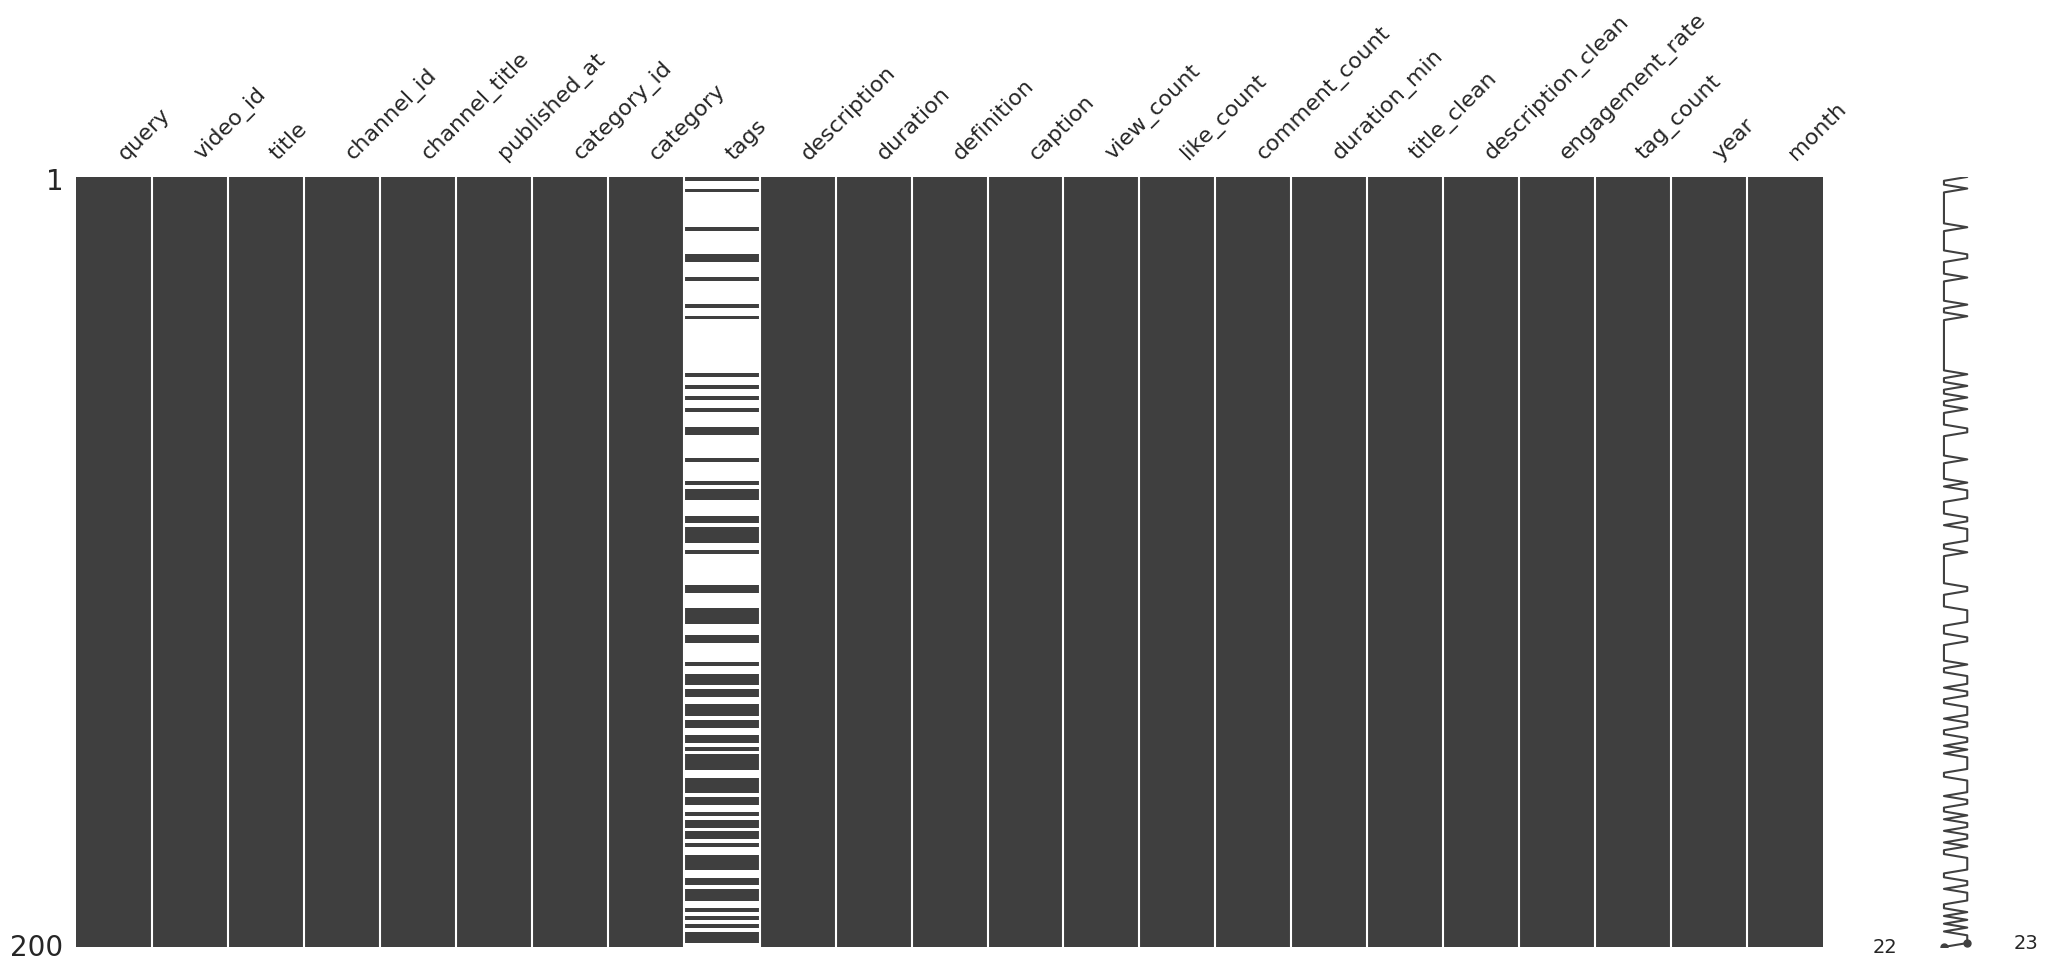

In [12]:
# 6.2 Missing values heatmap
import missingno as msno  # pip install missingno
msno.matrix(processed_df)
plt.show()

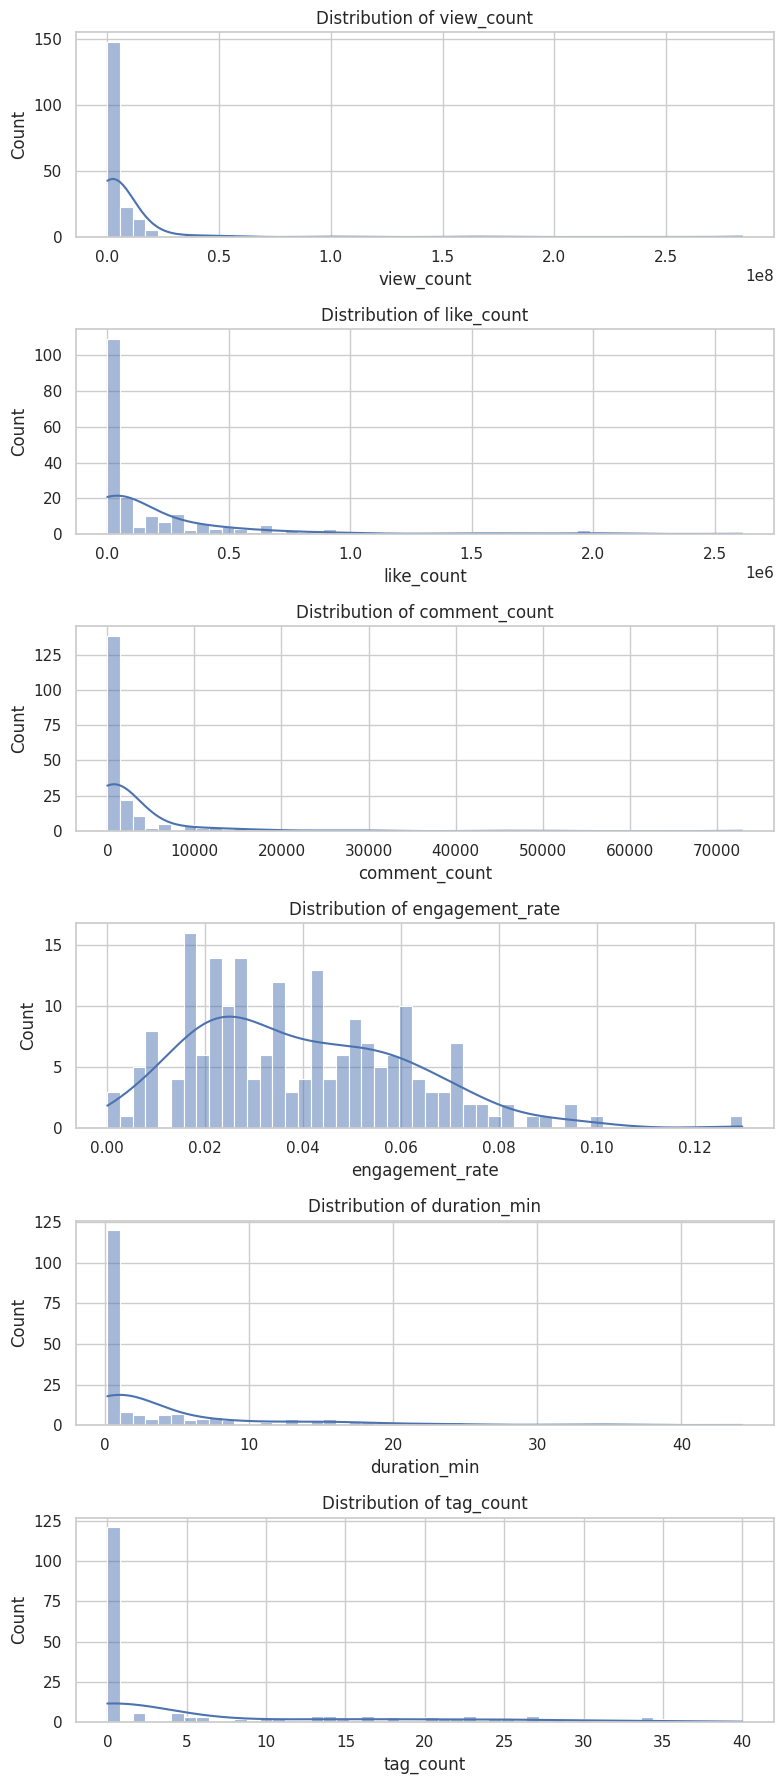

In [13]:
# 6.3 Distribution plots for numeric metrics
numeric_cols = ["view_count", "like_count", "comment_count", "engagement_rate", "duration_min", "tag_count"]

fig, axes = plt.subplots(len(numeric_cols), 1, figsize=(8, 3*len(numeric_cols)))
for ax, col in zip(axes, numeric_cols):
    sns.histplot(data=processed_df, x=col, bins=50, ax=ax, kde=True)
    ax.set_title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

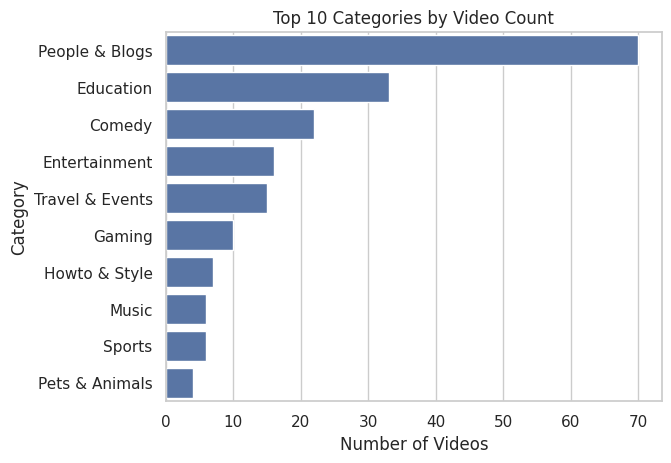

In [14]:
# 6.4 Top categories by video count
top_cats = processed_df["category"].value_counts().head(10)
sns.barplot(x=top_cats.values, y=top_cats.index)
plt.title("Top 10 Categories by Video Count")
plt.xlabel("Number of Videos")
plt.ylabel("Category")
plt.show()


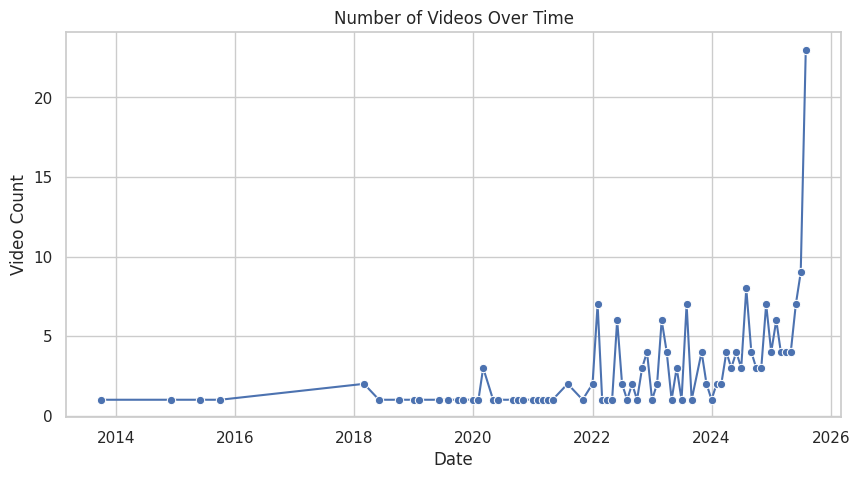

In [15]:
# 6.5 Trends over time: video count per month
videos_per_month = processed_df.groupby(["year", "month"]).size().reset_index(name="video_count")
videos_per_month["date"] = pd.to_datetime(videos_per_month[["year", "month"]].assign(day=1))

plt.figure(figsize=(10,5))
sns.lineplot(data=videos_per_month, x="date", y="video_count", marker="o")
plt.title("Number of Videos Over Time")
plt.ylabel("Video Count")
plt.xlabel("Date")
plt.show()


# Performance & Engagement Analysis

Identify top videos, explore correlations between metrics, and examine engagement patterns.

In [16]:
# 7.1 Top videos by views, likes, comments
def show_top(df, col, n=10):
    return df.sort_values(by=col, ascending=False)[
        ["query", "title", "channel_title", col, "engagement_rate"]
    ].head(n)

print("Top Videos by Views")
display(show_top(processed_df, "view_count"))

print("Top Videos by Likes")
display(show_top(processed_df, "like_count"))

print("Top Videos by Comments")
display(show_top(processed_df, "comment_count"))


Top Videos by Views


,query,title,channel_title,view_count,engagement_rate
92,day in the life of,American Authors - Best Day Of My Life,AmericanAuthorsVEVO,284144564,0.009452
13,day in the life of,The Beatles - A Day In The Life,TheBeatlesVEVO,163460561,0.005922
3,day in the life of,Central Cee - Day In The Life [Music Video] |...,GRM Daily,98910962,0.009490
32,day in the life of,When our parents were young #shorts,Content Machine,55137560,0.035761
64,day in the life of,When our parents were young #shorts,Content Machine,55137560,0.035761
186,day in the life of,Day in the Life: Heart Surgeon,Adventist HealthCare,42319192,0.018548
28,day in the life of,Day in the life of a throuple #shorts,Content Machine,41664550,0.040095
109,day in the life of,A Day in the Life of a 5th Grade Teacher #shorts,Mrs. Woolley in 5th,35981707,0.041905
26,day in the life of,"day in the life of a ""full-time"" streamer",RoyalPear,34409890,0.041554
36,day in the life of,A Day In The Life (Remastered 2009),The Beatles - Topic,24339568,0.009366


Top Videos by Likes


,query,title,channel_title,like_count,engagement_rate
92,day in the life of,American Authors - Best Day Of My Life,AmericanAuthorsVEVO,2612824,0.009452
71,day in the life of,If Influencers Were Honest - Episode 2 “Day in...,Haley Kalil,2104611,0.095581
64,day in the life of,When our parents were young #shorts,Content Machine,1962592,0.035761
32,day in the life of,When our parents were young #shorts,Content Machine,1962592,0.035761
28,day in the life of,Day in the life of a throuple #shorts,Content Machine,1659899,0.040095
109,day in the life of,A Day in the Life of a 5th Grade Teacher #shorts,Mrs. Woolley in 5th,1500210,0.041905
26,day in the life of,"day in the life of a ""full-time"" streamer",RoyalPear,1419485,0.041554
85,day in the life of,Day in the life of a crazy ex girlfriend #shorts,Content Machine,1068052,0.052348
1,day in the life of,Day in the life of platonic friends #shorts,Content Machine,932386,0.056420
3,day in the life of,Central Cee - Day In The Life [Music Video] |...,GRM Daily,926267,0.009490


Top Videos by Comments


,query,title,channel_title,comment_count,engagement_rate
92,day in the life of,American Authors - Best Day Of My Life,AmericanAuthorsVEVO,72931,0.009452
13,day in the life of,The Beatles - A Day In The Life,TheBeatlesVEVO,49909,0.005922
197,day in the life of,Day in the Life of a Japanese Delivery Worker,Paolo fromTOKYO,44127,0.022939
183,day in the life of,A Festive Day in the Life of Dan and Phil!,AmazingPhil,30003,0.035189
112,day in the life of,Day in the Life of a Japanese Manga Creator,Paolo fromTOKYO,27722,0.042402
186,day in the life of,Day in the Life: Heart Surgeon,Adventist HealthCare,25057,0.018548
142,day in the life of,A Day in the Life of a Minimalist,Matt D'Avella,20051,0.029078
21,day in the life of,A day in the life of an Australian,Fairbairn Films,17975,0.063067
173,day in the life of,A Day in the Life of Markiplier,Markiplier,17088,0.054030
111,day in the life of,Day in a life,Issey Moloney,15691,0.033149


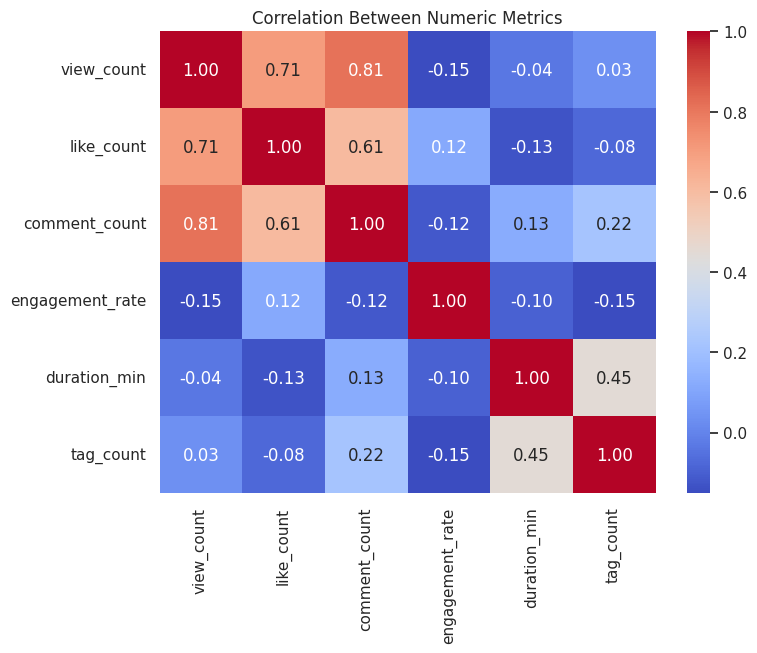

In [17]:
# 7.2 Correlation heatmap for numeric metrics
corr = processed_df[["view_count", "like_count", "comment_count", "engagement_rate", "duration_min", "tag_count"]].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Numeric Metrics")
plt.show()


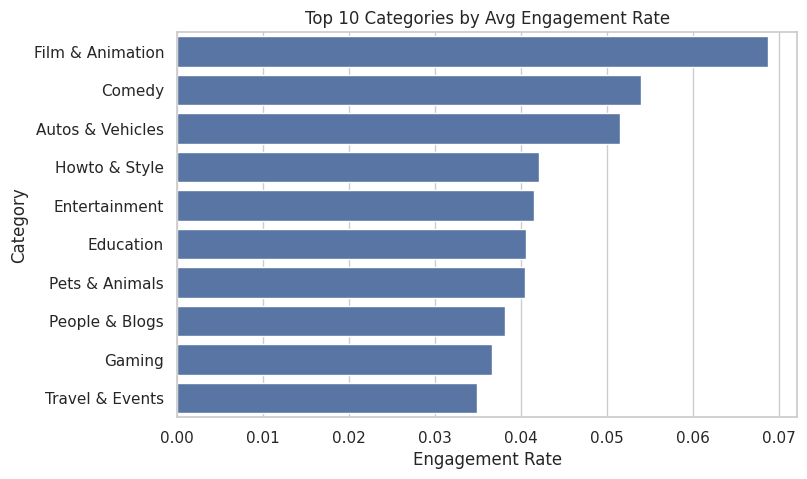

In [18]:
# 7.3 Engagement rate by category
eng_by_cat = processed_df.groupby("category")["engagement_rate"].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(8,5))
sns.barplot(x=eng_by_cat.values, y=eng_by_cat.index)
plt.title("Top 10 Categories by Avg Engagement Rate")
plt.xlabel("Engagement Rate")
plt.ylabel("Category")
plt.show()


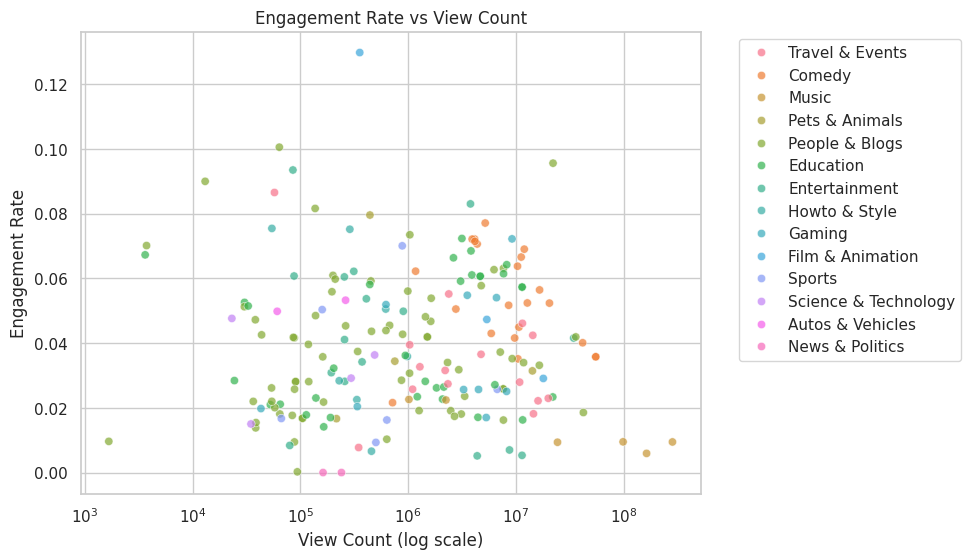

In [19]:
# 7.4 Engagement vs Views scatter
plt.figure(figsize=(8,6))
sns.scatterplot(data=processed_df, x="view_count", y="engagement_rate", hue="category", alpha=0.7)
plt.xscale("log")
plt.title("Engagement Rate vs View Count")
plt.xlabel("View Count (log scale)")
plt.ylabel("Engagement Rate")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


# Advanced Analysis (Optional)

Add deeper insights such as sentiment analysis on titles/descriptions, video clustering, or trend detection.

In [20]:
# 8.1 Sentiment analysis on titles
analyzer = SentimentIntensityAnalyzer()

def sentiment_score(text):
    if not isinstance(text, str) or not text.strip():
        return 0.0
    return analyzer.polarity_scores(text)["compound"]

processed_df["sentiment_title"] = processed_df["title_clean"].apply(sentiment_score)
processed_df["sentiment_desc"] = processed_df["description_clean"].apply(sentiment_score)

print("Sentiment columns added.")
display(processed_df[["title_clean", "sentiment_title", "sentiment_desc"]].head())


Sentiment columns added.


,title_clean,sentiment_title,sentiment_desc
0,Day in the Life of a Japanese Retail Store Worker,0.0000,0.9934
1,Day in the life of platonic friends #shorts,0.4767,0.0000
2,Day in the life of a toddler #shorts,0.0000,0.0000
3,Central Cee - Day In The Life [Music Video] | ...,0.0000,0.0000
4,Day in the life of boomer father #shorts,0.0000,0.0000


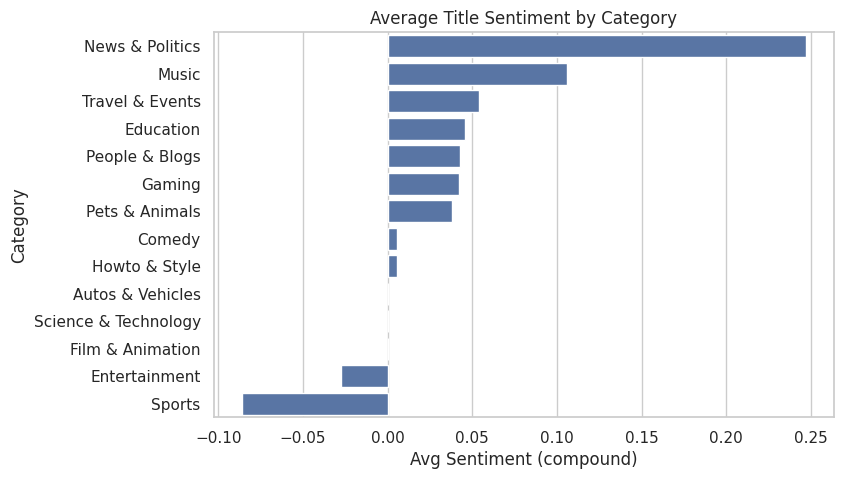

In [21]:
# 8.2 Average sentiment by category
avg_sentiment_cat = processed_df.groupby("category")[["sentiment_title", "sentiment_desc"]].mean().sort_values("sentiment_title", ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x=avg_sentiment_cat["sentiment_title"], y=avg_sentiment_cat.index)
plt.title("Average Title Sentiment by Category")
plt.xlabel("Avg Sentiment (compound)")
plt.ylabel("Category")
plt.show()


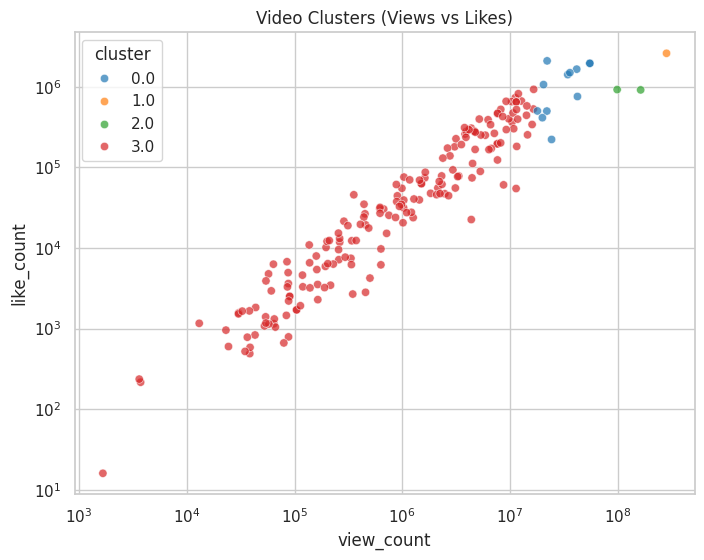

In [22]:
# 8.3 Clustering videos by views, likes, comments, duration
cluster_df = processed_df[["view_count", "like_count", "comment_count", "duration_min"]].dropna()

kmeans = KMeans(n_clusters=4, random_state=RANDOM_SEED)
cluster_labels = kmeans.fit_predict(cluster_df)

processed_df.loc[cluster_df.index, "cluster"] = cluster_labels

plt.figure(figsize=(8,6))
sns.scatterplot(
    x="view_count", y="like_count", hue="cluster",
    palette="tab10", data=processed_df, alpha=0.7
)
plt.xscale("log")
plt.yscale("log")
plt.title("Video Clusters (Views vs Likes)")
plt.show()


# Keyword Analysis (n-gram lift)

Compute n-gram statistics from titles/descriptions/tags and measure **lift** on a target metric (default: `views_per_day`).

In [23]:
# 10.1 Prereqs: tags_string + robust views_per_day (UTC-safe)

if "processed_df" not in globals():
    raise RuntimeError("Run Data Processing first to get processed_df.")

# Ensure published_at is timezone-aware UTC
pub = processed_df["published_at"]
if not pd.api.types.is_datetime64_any_dtype(pub):
    processed_df["published_at"] = pd.to_datetime(pub, utc=True, errors="coerce")
else:
    # If tz-naive -> localize to UTC; if tz-aware -> convert to UTC
    try:
        if getattr(processed_df["published_at"].dt, "tz", None) is None:
            processed_df["published_at"] = pd.to_datetime(processed_df["published_at"], utc=True, errors="coerce")
        else:
            processed_df["published_at"] = processed_df["published_at"].dt.tz_convert("UTC")
    except Exception:
        processed_df["published_at"] = pd.to_datetime(processed_df["published_at"], utc=True, errors="coerce")

# Build tags_string (comma-separated) for tokenization
def to_tags_string(tags):
    if isinstance(tags, list):
        return ", ".join([str(t) for t in tags if str(t).strip()])
    if isinstance(tags, str):
        return tags
    return ""

processed_df["tags_string"] = processed_df.get("tags", pd.Series([""] * len(processed_df))).apply(to_tags_string)

# Views per day since publish (avoid div-by-zero; clamp days>=1)
now_utc = pd.Timestamp.now(tz="UTC")
days_since_publish = (now_utc - processed_df["published_at"]).dt.total_seconds() / (24 * 3600)
days_since_publish = pd.to_numeric(days_since_publish, errors="coerce").fillna(1.0).clip(lower=1.0)

processed_df["views_per_day"] = processed_df["view_count"] / days_since_publish
print("Keyword analysis prerequisites ready: tags_string, views_per_day (UTC-safe).")


Keyword analysis prerequisites ready: tags_string, views_per_day (UTC-safe).


In [24]:
# 10.2 KeywordAnalysis module (paste-in)
"""
Keyword Analysis Module

Computes n-gram statistics from video text fields and measures lift on a target metric
(default: views_per_day).
"""

from __future__ import annotations

import logging
from collections import defaultdict
from typing import Dict, Iterable, List, Literal, Tuple, Optional, Set

import numpy as np
import pandas as pd

logger = logging.getLogger(__name__)
TextSource = Literal["title", "description", "tags"]


class KeywordAnalyzer:
    """Compute n-gram lift against a numeric metric such as views_per_day."""

    def __init__(self) -> None:
        pass

    def compute_ngram_lift(
        self,
        df: pd.DataFrame,
        *,
        text_source: TextSource = "title",
        n: int = 2,
        min_support: int = 3,
        metric: str = "views_per_day",
        max_results: int = 50,
        stopwords: Optional[Iterable[str]] = None,
        min_token_length: int = 3,
        remove_numeric_tokens: bool = True,
    ) -> pd.DataFrame:
        """
        Compute n-gram lift: average metric for videos containing the n-gram
        divided by the overall average metric.

        Returns columns: ngram, count, avg_metric, baseline_avg, lift
        """
        if metric not in df.columns:
            raise ValueError(f"Metric column '{metric}' not found in dataframe")

        # Baseline average (prefer non-zero to avoid dilution)
        metric_series = pd.to_numeric(df[metric], errors="coerce").fillna(0.0)
        nonzero = metric_series[metric_series > 0]
        baseline_avg = (nonzero.mean() if len(nonzero) > 0 else metric_series.mean()) or 0.0
        if baseline_avg == 0:
            logger.warning("Baseline metric average is 0; cannot compute lift meaningfully.")
            return pd.DataFrame(columns=["ngram", "count", "avg_metric", "baseline_avg", "lift"])

        # Build tokens per row depending on text source
        tokens_per_row: List[List[str]] = []
        stopwords_set: Set[str] = set((s or "").lower() for s in (stopwords or []))

        if text_source == "title":
            source_col = "title_clean" if "title_clean" in df.columns else "title"
            for text in df[source_col].fillna(""):
                tokens_per_row.append(
                    self._tokenize_text(
                        text,
                        stopwords=stopwords_set,
                        min_token_length=min_token_length,
                        remove_numeric_tokens=remove_numeric_tokens,
                    )
                )
        elif text_source == "description":
            source_col = "description_clean" if "description_clean" in df.columns else "description"
            for text in df[source_col].fillna(""):
                tokens_per_row.append(
                    self._tokenize_text(
                        text,
                        stopwords=stopwords_set,
                        min_token_length=min_token_length,
                        remove_numeric_tokens=remove_numeric_tokens,
                    )
                )
        elif text_source == "tags":
            # Tags as comma-separated string -> per-word tokens
            for tags_str in df.get("tags_string", pd.Series([""] * len(df))).fillna(""):
                tags = [t.strip() for t in tags_str.split(",") if t.strip()]
                tokens = []
                for t in tags:
                    tokens.extend(
                        self._tokenize_text(
                            t,
                            stopwords=stopwords_set,
                            min_token_length=min_token_length,
                            remove_numeric_tokens=remove_numeric_tokens,
                        )
                    )
                tokens_per_row.append(tokens)
        else:
            raise ValueError(f"Unsupported text_source: {text_source}")

        # Build distinct n-grams per row
        n = max(1, min(int(n), 5))
        row_ngrams: List[List[str]] = [sorted(set(self._generate_ngrams(tokens, n))) for tokens in tokens_per_row]

        # Aggregate counts and metric sums
        from collections import defaultdict
        ngram_counts: Dict[str, int] = defaultdict(int)
        ngram_metric_sum: Dict[str, float] = defaultdict(float)

        for row_idx, ngrams in enumerate(row_ngrams):
            row_metric = float(metric_series.iat[row_idx])
            if not ngrams:
                continue
            for ng in ngrams:
                ngram_counts[ng] += 1
                ngram_metric_sum[ng] += row_metric

        # Build result
        records: List[Tuple[str, int, float, float, float]] = []
        for ng, count in ngram_counts.items():
            if count < min_support:
                continue
            avg_metric = ngram_metric_sum[ng] / max(count, 1)
            lift = avg_metric / baseline_avg if baseline_avg > 0 else np.nan
            records.append((ng, count, avg_metric, baseline_avg, lift))

        result = pd.DataFrame(records, columns=["ngram", "count", "avg_metric", "baseline_avg", "lift"])
        if result.empty:
            return result

        result = result.sort_values(["lift", "count"], ascending=[False, False]).head(max_results)
        return result

    def _tokenize_text(
        self,
        text: str,
        *,
        stopwords: Optional[Set[str]] = None,
        min_token_length: int = 3,
        remove_numeric_tokens: bool = True,
    ) -> List[str]:
        text = (text or "").lower()
        raw = "".join(c if c.isalnum() or c.isspace() else " " for c in text)
        raw = " ".join(raw.split())
        tokens = []
        for t in raw.split(" ") if raw else []:
            if not t:
                continue
            if remove_numeric_tokens and t.isnumeric():
                continue
            if len(t) < max(1, int(min_token_length)):
                continue
            if stopwords and t in stopwords:
                continue
            tokens.append(t)
        return tokens

    def _generate_ngrams(self, tokens: List[str], n: int) -> Iterable[str]:
        if n <= 1:
            for t in tokens:
                yield t
            return
        for i in range(len(tokens) - n + 1):
            yield " ".join(tokens[i : i + n])


In [25]:
# 10.3 Quick usage examples

ka = KeywordAnalyzer()

# Top bigrams in titles by lift on views_per_day
title_bigrams = ka.compute_ngram_lift(
    processed_df,
    text_source="title",
    n=2,
    min_support=3,
    metric="views_per_day",
    max_results=30,
    stopwords={"the","a","an","and","or","to","of","in","on","for","with","my","your"}
)
display(title_bigrams)

# Top unigrams in tags by lift
tag_unigrams = ka.compute_ngram_lift(
    processed_df,
    text_source="tags",
    n=1,
    min_support=3,
    metric="views_per_day",
    max_results=30
)
display(tag_unigrams)

# Top trigrams in descriptions by lift (may be sparse)
desc_trigrams = ka.compute_ngram_lift(
    processed_df,
    text_source="description",
    n=3,
    min_support=5,
    metric="views_per_day",
    max_results=20
)
display(desc_trigrams)


,ngram,count,avg_metric,baseline_avg,lift
2,life german,3,74290.311977,26200.844499,2.835417
4,life stanford,3,32739.500861,26200.844499,1.249559
5,productivity studytips,3,32739.500861,26200.844499,1.249559
6,studywithme productivity,3,32739.500861,26200.844499,1.249559
0,day life,193,24441.131893,26200.844499,0.932838
1,life japanese,9,14576.606737,26200.844499,0.556341
17,life ceo,3,14461.867827,26200.844499,0.551962
8,full time,4,14394.295136,26200.844499,0.549383
9,life full,4,14394.295136,26200.844499,0.549383
7,year old,3,10511.573312,26200.844499,0.401192


,ngram,count,avg_metric,baseline_avg,lift
62,best,3,28635.734751,26200.844499,1.092932
13,workday,3,26835.464083,26200.844499,1.024221
17,music,4,26750.327673,26200.844499,1.020972
18,video,4,26643.841005,26200.844499,1.016908
73,car,3,24239.207339,26200.844499,0.925131
15,workers,3,21569.048862,26200.844499,0.823220
68,engineering,3,20267.845388,26200.844499,0.773557
51,food,3,18739.992318,26200.844499,0.715244
22,what,5,18556.659650,26200.844499,0.708247
69,programming,3,17217.236208,26200.844499,0.657125


,ngram,count,avg_metric,baseline_avg,lift
43,day the life,39,39299.956973,26200.844499,1.499950
61,fromtokyo premium kaminari,5,19660.558764,26200.844499,0.750379
65,get paolo fromtokyo,5,19660.558764,26200.844499,0.750379
91,kaminari hot sauce,5,19660.558764,26200.844499,0.750379
122,paolo fromtokyo premium,5,19660.558764,26200.844499,0.750379
130,premium kaminari hot,5,19660.558764,26200.844499,0.750379
148,support tokyo zebra,8,14976.985115,26200.844499,0.571622
193,your support tokyo,8,14976.985115,26200.844499,0.571622
40,community channel support,8,14573.984115,26200.844499,0.556241
45,discord community channel,8,14573.984115,26200.844499,0.556241


In [26]:
# 10.4 Visualization: bar chart for n-gram lift (with counts)

import matplotlib.pyplot as plt
import numpy as np

def plot_ngram_lift(ngram_df: pd.DataFrame, title: str = "N-gram Lift", top: int = 20):
    """
    Plot top n-grams by lift with support counts labeled.
    Expects columns: ['ngram','lift','count'] (as returned by KeywordAnalyzer).
    """
    if ngram_df is None or ngram_df.empty:
        print("Nothing to plot: received empty dataframe.")
        return

    # Take top rows by lift
    d = ngram_df.sort_values(["lift","count"], ascending=[False, False]).head(top).copy()

    # Basic formatting
    d["label"] = d["ngram"].astype(str)
    y = d["lift"].values
    labels = d["label"].values
    counts = d["count"].values

    # Figure
    plt.figure(figsize=(10, max(4, 0.4 * len(d))))
    bars = plt.barh(range(len(d)), y)
    plt.gca().invert_yaxis()  # highest lift at top

    # Axis labels and title
    plt.yticks(range(len(d)), labels)
    plt.xlabel("Lift vs baseline")
    plt.title(title)

    # Annotate counts at the end of bars
    for i, (bar, c) in enumerate(zip(bars, counts)):
        w = bar.get_width()
        plt.text(w + max(0.02, 0.01 * y.max()), bar.get_y() + bar.get_height()/2,
                 f"n={c}", va="center", fontsize=9)

    # Add a vertical line at lift=1 (baseline)
    plt.axvline(1.0, linestyle="--", linewidth=1)

    plt.tight_layout()
    plt.show()


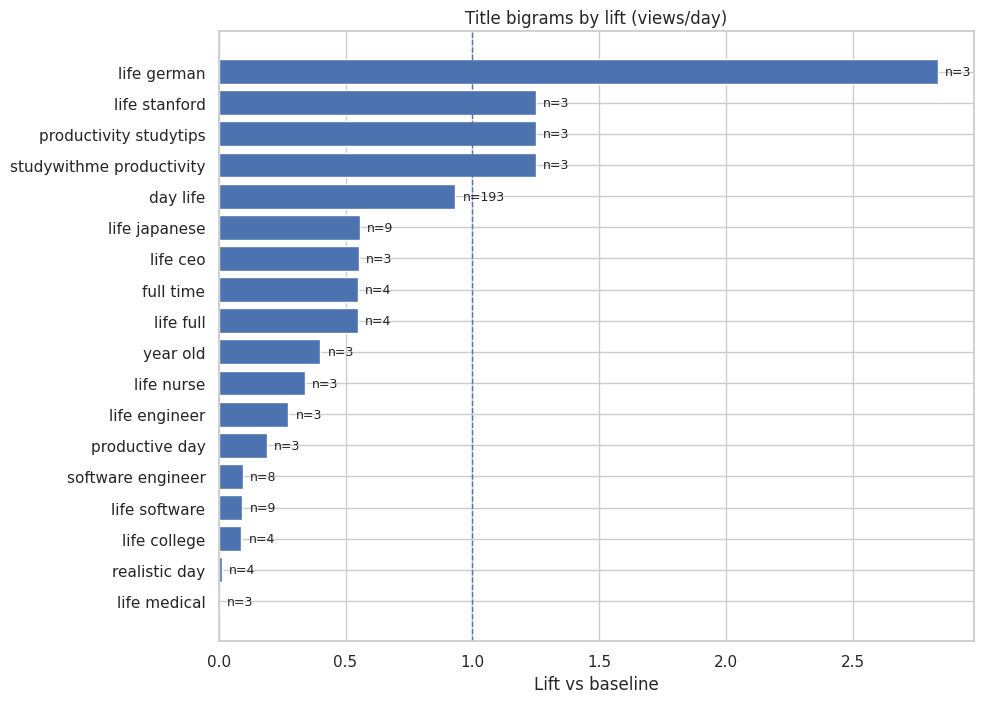

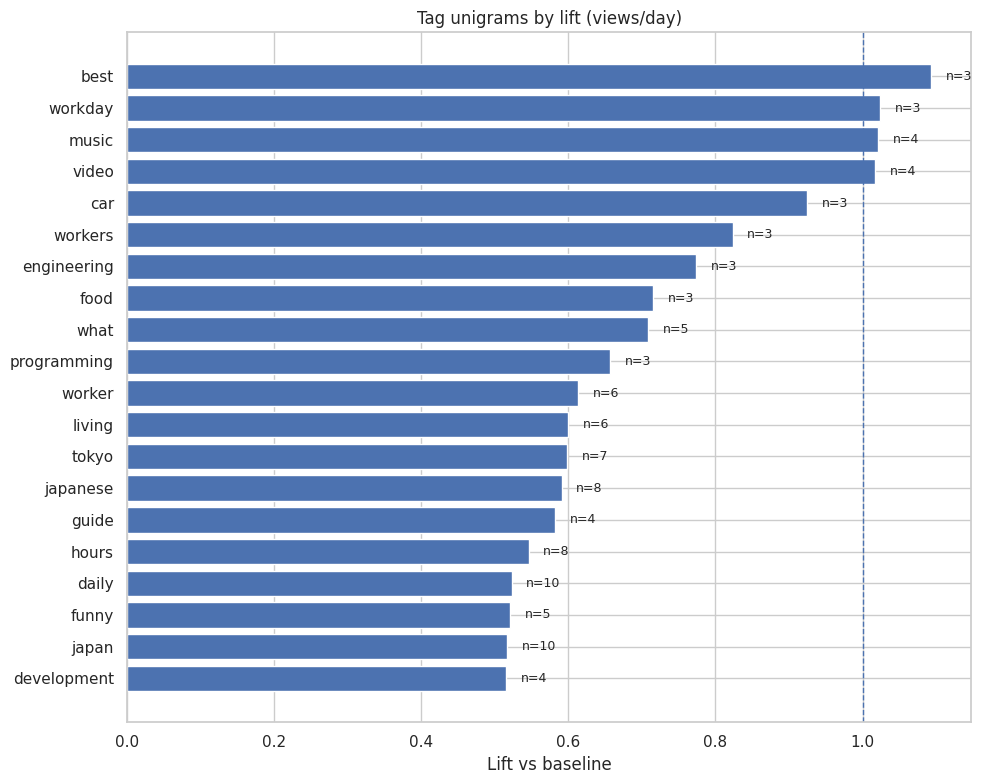

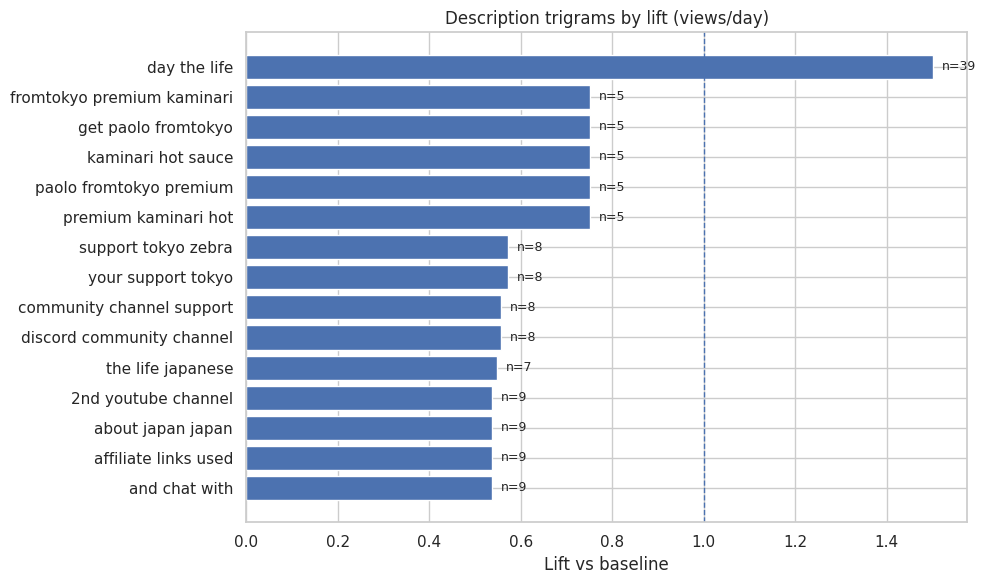

In [27]:
plot_ngram_lift(title_bigrams, title="Title bigrams by lift (views/day)", top=20)
plot_ngram_lift(tag_unigrams, title="Tag unigrams by lift (views/day)", top=20)
plot_ngram_lift(desc_trigrams, title="Description trigrams by lift (views/day)", top=15)